# RNN - Model

In [79]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [80]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [81]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [82]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [83]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [84]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [85]:
df.shape

(5813, 65)

### Drop features with std = 0

In [86]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [87]:
df.shape

(5813, 41)

### Drop corrected features

In [88]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [89]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [90]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [91]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [92]:
df.drop(columns=remove, inplace=True)

## Impute features with <30% NaN values

In [93]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [94]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [17]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

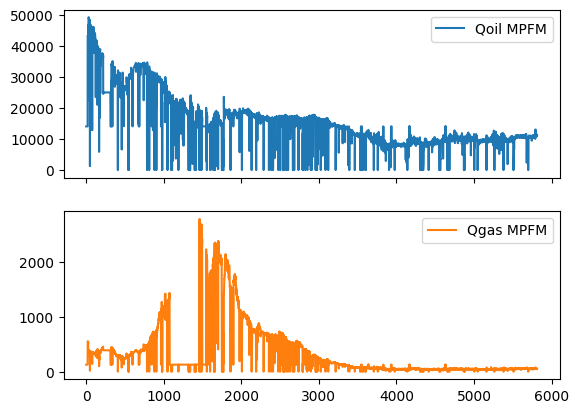

In [18]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

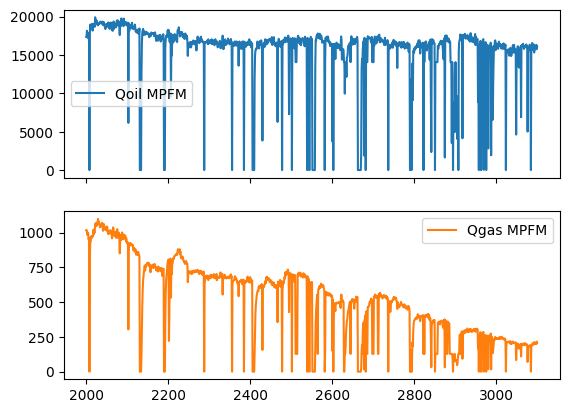

In [19]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [20]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [21]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [22]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [23]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [24]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [25]:
INPUT_LENGTH = 14 #two weeks

In [26]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [27]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [28]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [29]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [30]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [31]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [32]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [33]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [34]:
SEQUENCE_STRIDE = 1

In [35]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [36]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [37]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [56]:
X_train.shape

(3680, 3)

In [58]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

#### Baseline model

In [42]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [43]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} m3")

24/24 [==============================] - 0s 314us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3


2023-03-22 18:39:16.449186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Initial model from Weather prediction challenge but with batch_size=8 and epochs=150

In [44]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [45]:
model_init = init_model(X_train, y_train)
model_init.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [46]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model: models, verbose=1) -> tuple[models, dict]:
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [47]:
model_init, history_init = fit_model(model_init)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 995914304.0000 - mae: 30738.6191 - val_loss: 365787008.0000 - val_mae: 17616.0566
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987597056.0000 - mae: 30605.1953 - val_loss: 360920608.0000 - val_mae: 17504.1797
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 978200832.0000 - mae: 30454.7578 - val_loss: 355992000.0000 - val_mae: 17391.0195
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 968999360.0000 - mae: 30306.2988 - val_loss: 351088160.0000 - val_mae: 17275.3242
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 959917184.0000 - mae: 30159.0547 - val_loss: 346222336.0000 - val_mae: 17160.7754
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 950924928.0000 - mae: 30012.5273 - val_loss: 341432352.0000 - val_mae: 17047.0469
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 590305856.0000 - mae: 23389.2500 - val_loss: 160917296.0000 - val_mae: 11828.6914
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 583754112.0000 - mae: 23251.4102 - val_loss: 157734256.0000 - val_mae: 11706.8340
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 577246720.0000 - mae: 23113.6797 - val_loss: 154801488.0000 - val_mae: 11595.6113
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 570783488.0000 - mae: 22976.0020 - val_loss: 151957408.0000 - val_mae: 11489.1650
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 564363840.0000 - mae: 22838.4238 - val_loss: 149187168.0000 - val_mae: 11385.1221
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 557987904.0000 - mae: 22700.9336 - val_loss: 146438384.0000 - val_mae: 11280.0547
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

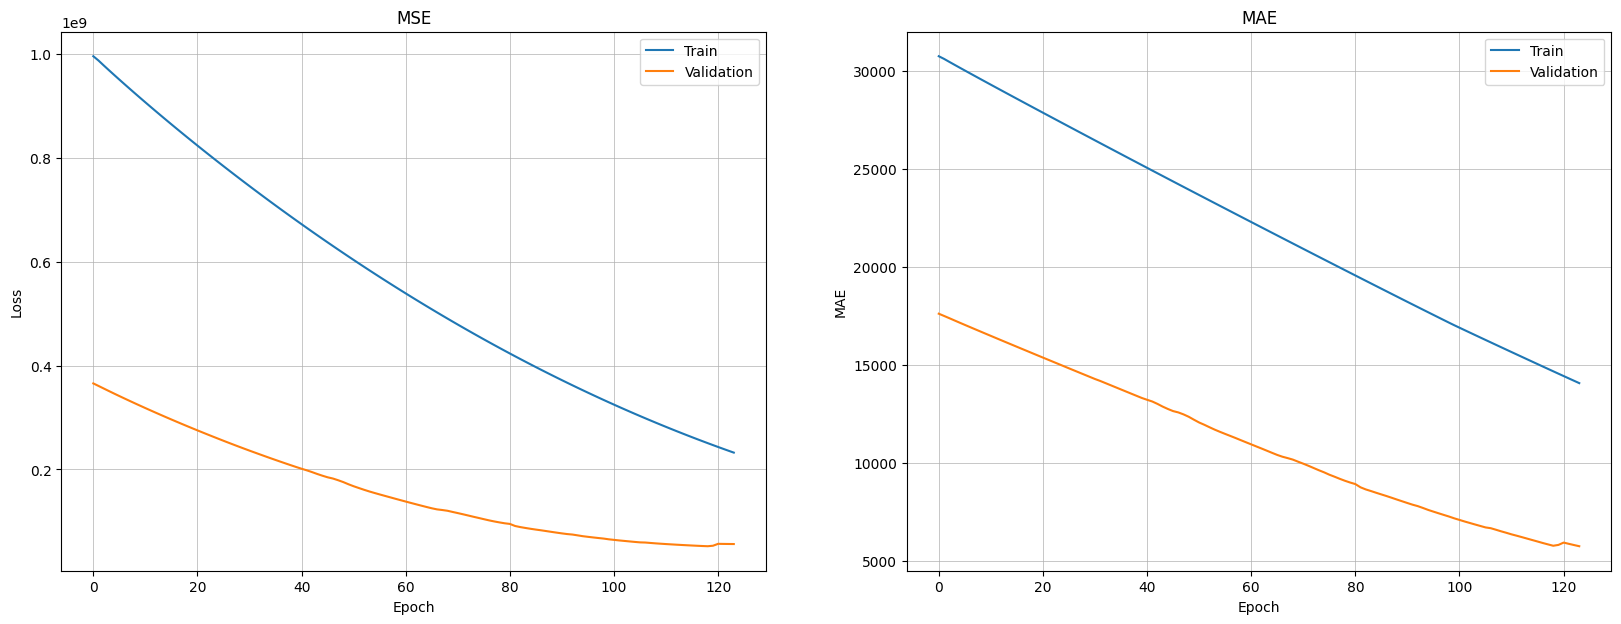

In [48]:
plot_history(history_init)

In [49]:
res = model_init.evaluate(X_test, y_test, verbose=0)
res

[21534168.0, 2683.525634765625]

In [50]:
mae_results = {}

In [51]:
mae_results['res'] = res[1]

#### Initial model with LSTM 128 neurons

In [52]:
def init_model_2(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [53]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [55]:
model_2, history_2 = fit_model(model_2)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 995156288.0000 - mae: 30726.2832 - val_loss: 369061408.0000 - val_mae: 17694.3457
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 989057920.0000 - mae: 30634.7598 - val_loss: 363064640.0000 - val_mae: 17557.5078
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 980935808.0000 - mae: 30497.6758 - val_loss: 355758784.0000 - val_mae: 17391.5820
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 969476160.0000 - mae: 30313.6016 - val_loss: 349794560.0000 - val_mae: 17254.6211
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 959392832.0000 - mae: 30150.3105 - val_loss: 344288192.0000 - val_mae: 17126.9316
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 949878848.0000 - mae: 29995.3203 - val_loss: 339039776.0000 - val_mae: 17004.0918
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 595354816.0000 - mae: 23494.9473 - val_loss: 159794512.0000 - val_mae: 11895.1807
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 588857600.0000 - mae: 23358.9004 - val_loss: 156974320.0000 - val_mae: 11791.9414
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 582405248.0000 - mae: 23222.9785 - val_loss: 154195360.0000 - val_mae: 11688.9033
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 575996800.0000 - mae: 23087.1582 - val_loss: 151457632.0000 - val_mae: 11587.4619
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 569632896.0000 - mae: 22951.4668 - val_loss: 148760944.0000 - val_mae: 11486.4229
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 563313024.0000 - mae: 22815.8809 - val_loss: 146105200.0000 - val_mae: 11385.4658
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

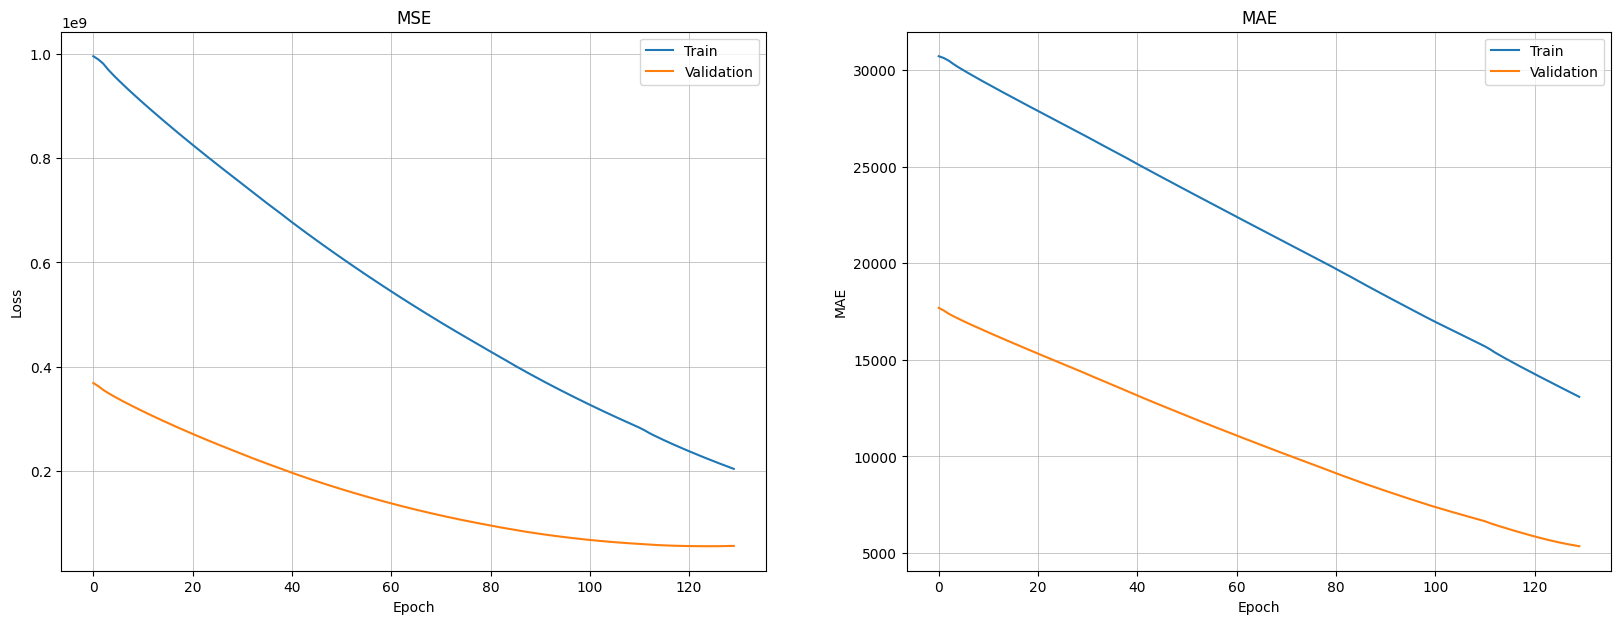

In [56]:
plot_history(history_2)

In [57]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[24139206.0, 2534.969482421875]

In [58]:
mae_results['res2'] = res2[1]

#### Initial model but with one more LSTM layer

In [59]:
def init_model_3(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [60]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 117,064
Trainable params: 117,057
Non-trainable params: 7
________________________________________________

In [61]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [62]:
model_3, history_3 = fit_model(model_3)

Epoch 1/150
125/125 [==============================] - 2s 9ms/step - loss: 996257088.0000 - mae: 30744.3574 - val_loss: 365776640.0000 - val_mae: 17618.6133
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 987880256.0000 - mae: 30610.2227 - val_loss: 360705888.0000 - val_mae: 17504.1738
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 979107200.0000 - mae: 30469.4629 - val_loss: 355745600.0000 - val_mae: 17391.3047
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 970450816.0000 - mae: 30329.9043 - val_loss: 350850112.0000 - val_mae: 17278.9941
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 961869760.0000 - mae: 30190.9082 - val_loss: 346010720.0000 - val_mae: 17167.0430
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 953354944.0000 - mae: 30052.3301 - val_loss: 341224256.0000 - val_mae: 17055.3926
Epoch 7/150
125/125 [==============================] - 1s 

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 607286016.0000 - mae: 23742.7969 - val_loss: 165082608.0000 - val_mae: 12085.0352
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 600935360.0000 - mae: 23611.2715 - val_loss: 162285696.0000 - val_mae: 11985.2109
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 594624960.0000 - mae: 23479.8262 - val_loss: 159526768.0000 - val_mae: 11885.4404
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 588354240.0000 - mae: 23348.4414 - val_loss: 156805728.0000 - val_mae: 11785.7256
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 582123392.0000 - mae: 23217.1426 - val_loss: 154122624.0000 - val_mae: 11686.2061
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 575932672.0000 - mae: 23085.9199 - val_loss: 151477360.0000 - val_mae: 11588.1992
Epoch 59/150
125/125 [==============================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

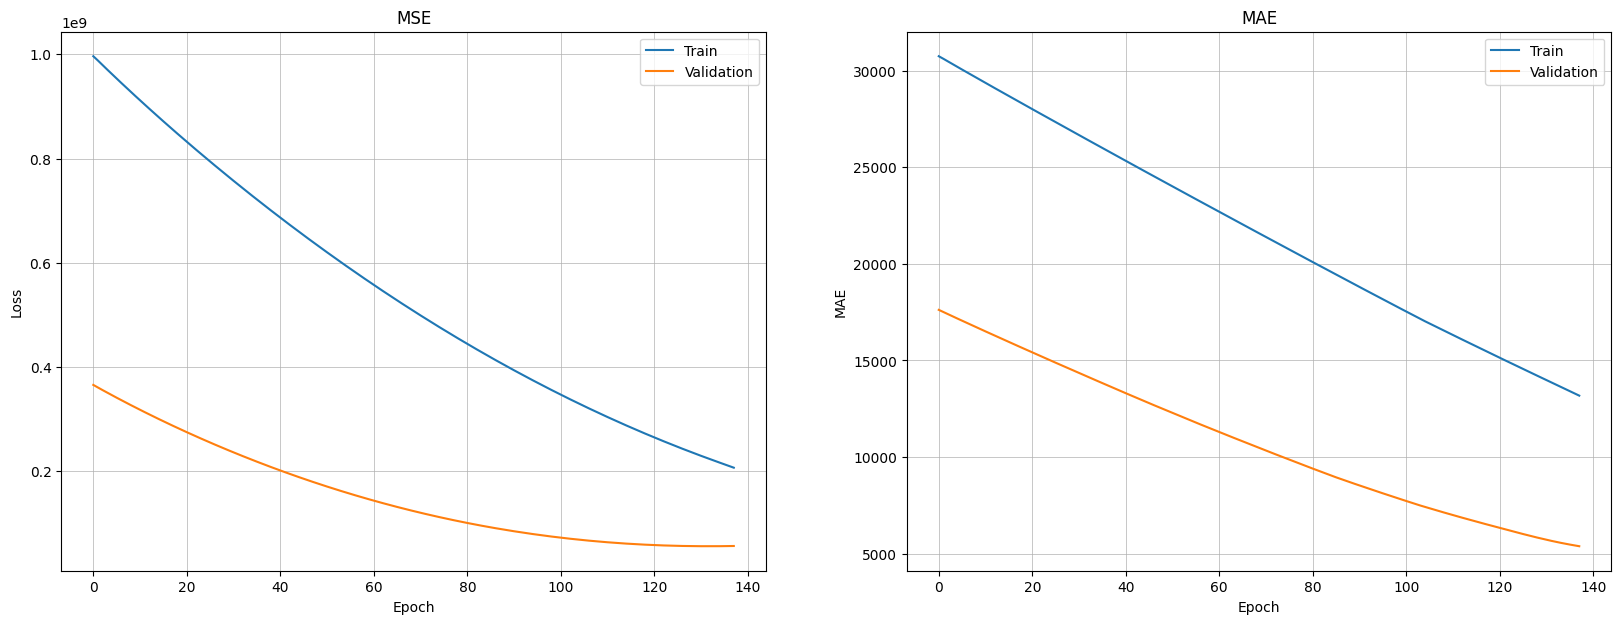

In [63]:
plot_history(history_3)

In [64]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[24067118.0, 2532.26953125]

In [65]:
mae_results['res3'] = res3[1]

In [66]:
print(mae_results)

{'res': 2683.525634765625, 'res2': 2534.969482421875, 'res3': 2532.26953125}


#### Add more layers

In [67]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [68]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [69]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [70]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 2s 10ms/step - loss: 996696384.0000 - mae: 30752.1035 - val_loss: 368433440.0000 - val_mae: 17678.4316
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 991746240.0000 - mae: 30670.5547 - val_loss: 364055008.0000 - val_mae: 17580.3008
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 984514624.0000 - mae: 30554.9434 - val_loss: 360502880.0000 - val_mae: 17500.1113
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 977177088.0000 - mae: 30438.1973 - val_loss: 357074496.0000 - val_mae: 17422.3203
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 970153920.0000 - mae: 30324.4551 - val_loss: 353515520.0000 - val_mae: 17341.0215
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 962992320.0000 - mae: 30208.3691 - val_loss: 349805376.0000 - val_mae: 17255.6875
Epoch 7/150
125/125 [==============================] - 1s

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 596156416.0000 - mae: 23506.7461 - val_loss: 189480240.0000 - val_mae: 12960.0430
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 588868032.0000 - mae: 23357.4316 - val_loss: 186782560.0000 - val_mae: 12874.0078
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 584070656.0000 - mae: 23257.7930 - val_loss: 184113664.0000 - val_mae: 12787.1504
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 576258752.0000 - mae: 23089.4746 - val_loss: 181462704.0000 - val_mae: 12700.2080
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 570511680.0000 - mae: 22966.7930 - val_loss: 178841280.0000 - val_mae: 12613.5439
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 563674880.0000 - mae: 22826.1133 - val_loss: 176246320.0000 - val_mae: 12526.8213
Epoch 59/150
125/125 [==============================

Epoch 105/150
125/125 [==============================] - 1s 6ms/step - loss: 312801856.0000 - mae: 16554.3359 - val_loss: 85180064.0000 - val_mae: 8620.4072
Epoch 106/150
125/125 [==============================] - 1s 6ms/step - loss: 307942208.0000 - mae: 16417.6523 - val_loss: 83905672.0000 - val_mae: 8542.9648
Epoch 107/150
125/125 [==============================] - 1s 6ms/step - loss: 305090848.0000 - mae: 16328.7354 - val_loss: 82704120.0000 - val_mae: 8467.8555
Epoch 108/150
125/125 [==============================] - 1s 6ms/step - loss: 299282496.0000 - mae: 16163.0234 - val_loss: 81551656.0000 - val_mae: 8394.1074
Epoch 109/150
125/125 [==============================] - 1s 6ms/step - loss: 296044576.0000 - mae: 16055.6338 - val_loss: 80423472.0000 - val_mae: 8320.4736
Epoch 110/150
125/125 [==============================] - 1s 6ms/step - loss: 292048736.0000 - mae: 15948.3193 - val_loss: 79231792.0000 - val_mae: 8241.3730
Epoch 111/150
125/125 [==============================] - 1

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

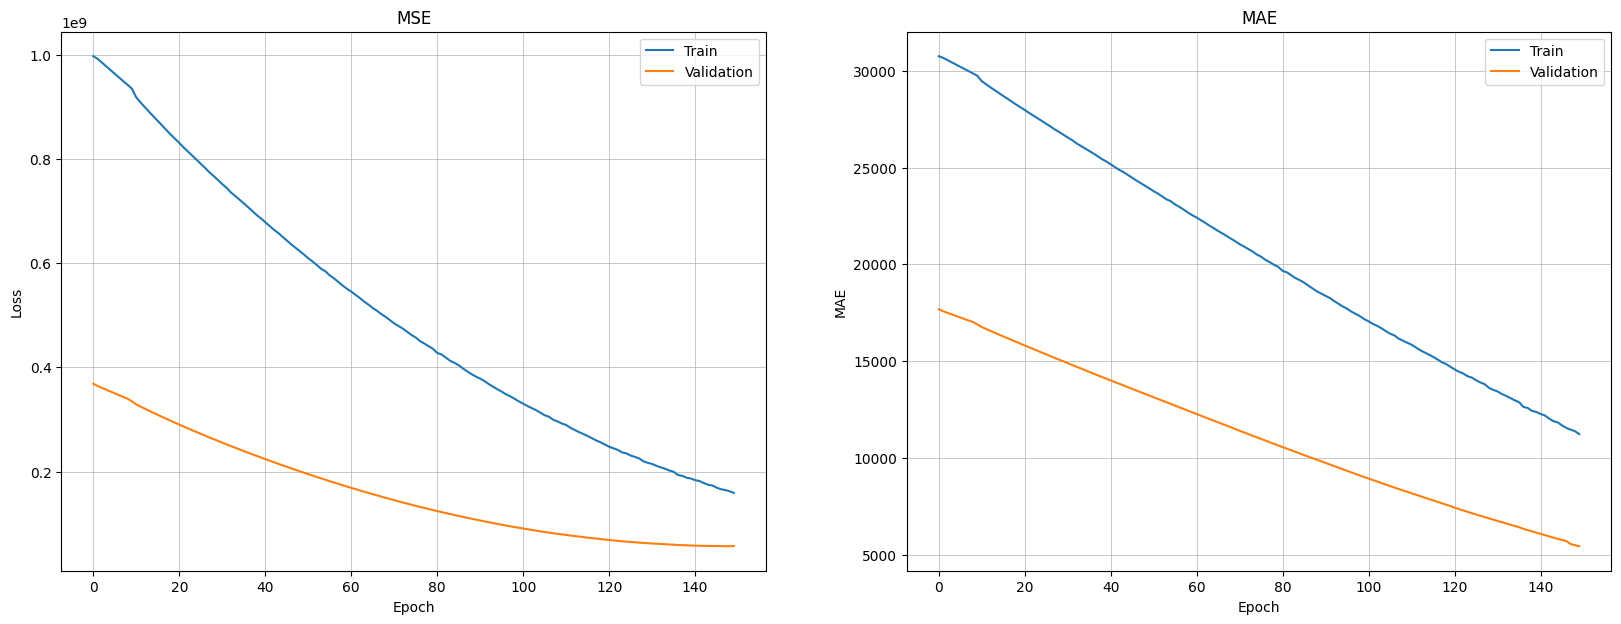

In [71]:
plot_history(history_4)

In [72]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[29043988.0, 3518.168701171875]

In [73]:
mae_results['res4'] = res4[1]

In [74]:
mae_results

{'res': 2683.525634765625,
 'res2': 2534.969482421875,
 'res3': 2532.26953125,
 'res4': 3518.168701171875}

#### Test with more features

In [202]:
df[['MPFM Venturi dP', 'WHT', 'Tubing Gradient']]

,MPFM Venturi dP,WHT,Tubing Gradient
0,1672.997986,51.247467,0.000000
1,1672.997986,51.247467,0.000000
2,1672.997986,51.247467,0.000000
3,1672.997986,51.247467,0.000000
4,1672.997986,51.247467,0.000000
...,...,...,...
5808,1687.935181,51.966740,1.003753
5809,1719.284912,51.968021,1.003906
5810,1742.380127,51.972717,1.005642
5811,1729.632324,51.982071,1.006597


In [296]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.15)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [297]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_50 (LSTM)              (None, 128)               67584     
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [298]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [299]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 964556736.0000 - mae: 30215.6406 - val_loss: 327854688.0000 - val_mae: 16739.6250
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 888815744.0000 - mae: 28958.2363 - val_loss: 287320896.0000 - val_mae: 15736.3643
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 816949440.0000 - mae: 27715.8789 - val_loss: 250696144.0000 - val_mae: 14758.2383
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 750925632.0000 - mae: 26525.0508 - val_loss: 222630672.0000 - val_mae: 13856.2500
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 685689728.0000 - mae: 25276.5391 - val_loss: 185955088.0000 - val_mae: 12695.2217
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 615159552.0000 - mae: 23872.2168 - val_loss: 155759152.0000 - val_mae: 11630.9375
Epoch 7/150
125/125 [==============================] - 0s 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

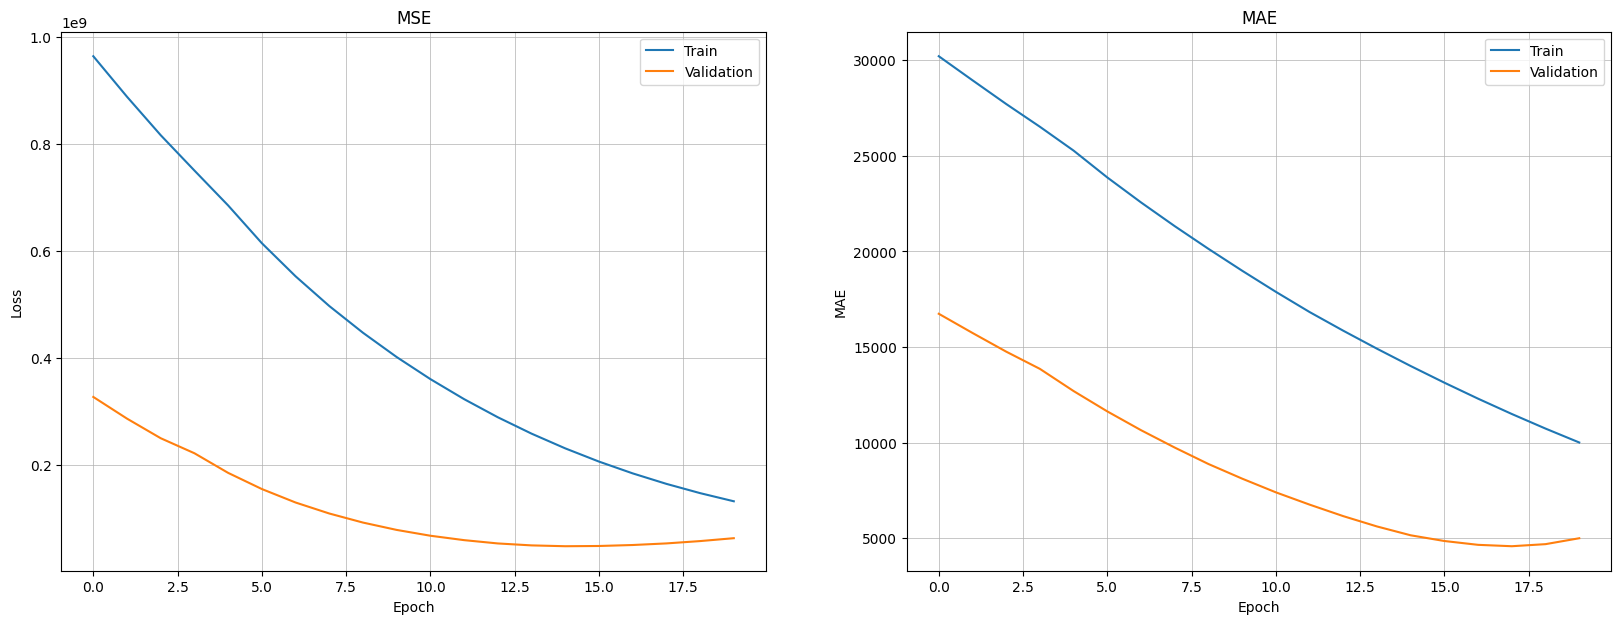

In [300]:
plot_history(history_4)

In [309]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[22892092.0, 2442.34619140625]

In [312]:
mae_results['res4'] = res4[1]

In [313]:
mae_results

{'res': 2532.921142578125,
 'res2': 2594.729736328125,
 'res3': 2493.5693359375,
 'res4': 2442.34619140625}

#### Applying a scaler to the df

In [565]:
FOLD_LENGTH

2190

In [566]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(df_LSTM)
df_LSTM_scaled = std_scaler.transform(df_LSTM)

In [567]:
df_LSTM_scaled = pd.DataFrame(df_LSTM_scaled, columns=df_LSTM.columns)

In [568]:
folds_longer = get_folds(df_LSTM_scaled, 365*3, FOLD_STRIDE)
fold_longer = folds_longer[0]
(fold_train_longer, fold_test_longer) = train_test_split(fold_longer, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_c, y_train_c = get_X_y_strides(fold_train_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_c, y_test_c = get_X_y_strides(fold_test_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_c.shape)
print(y_train_c.shape)

(708, 14, 3)
(708, 1, 1)


In [569]:
N_FEATURES

3

In [559]:
def init_model_5(X_train, y_train):
    
    #normalization
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    #model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', input_shape=(X_train_c.shape[1], X_train_c.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [560]:
model_5 = init_model_5(X_train_c, y_train_c)
model_5.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [561]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_mae", mode = "min")

def fit_model(model):
    
    history = model.fit(X_train_c, y_train_c,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=250,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [562]:
model_5, history_5 = fit_model(model_5)

Epoch 1/250
62/62 [==============================] - 2s 7ms/step - loss: 0.9333 - mae: 0.6695 - val_loss: 0.6518 - val_mae: 0.7323
Epoch 2/250
62/62 [==============================] - 0s 4ms/step - loss: 1.0010 - mae: 0.7356 - val_loss: 0.3131 - val_mae: 0.4198
Epoch 3/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9121 - mae: 0.7171 - val_loss: 0.3013 - val_mae: 0.3857
Epoch 4/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8924 - mae: 0.7198 - val_loss: 0.3543 - val_mae: 0.4467
Epoch 5/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8647 - mae: 0.6832 - val_loss: 0.2928 - val_mae: 0.3871
Epoch 6/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8888 - mae: 0.6834 - val_loss: 0.3434 - val_mae: 0.4574
Epoch 7/250
62/62 [==============================] - 0s 4ms/step - loss: 0.7312 - mae: 0.6160 - val_loss: 0.5694 - val_mae: 0.6840
Epoch 8/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9909 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

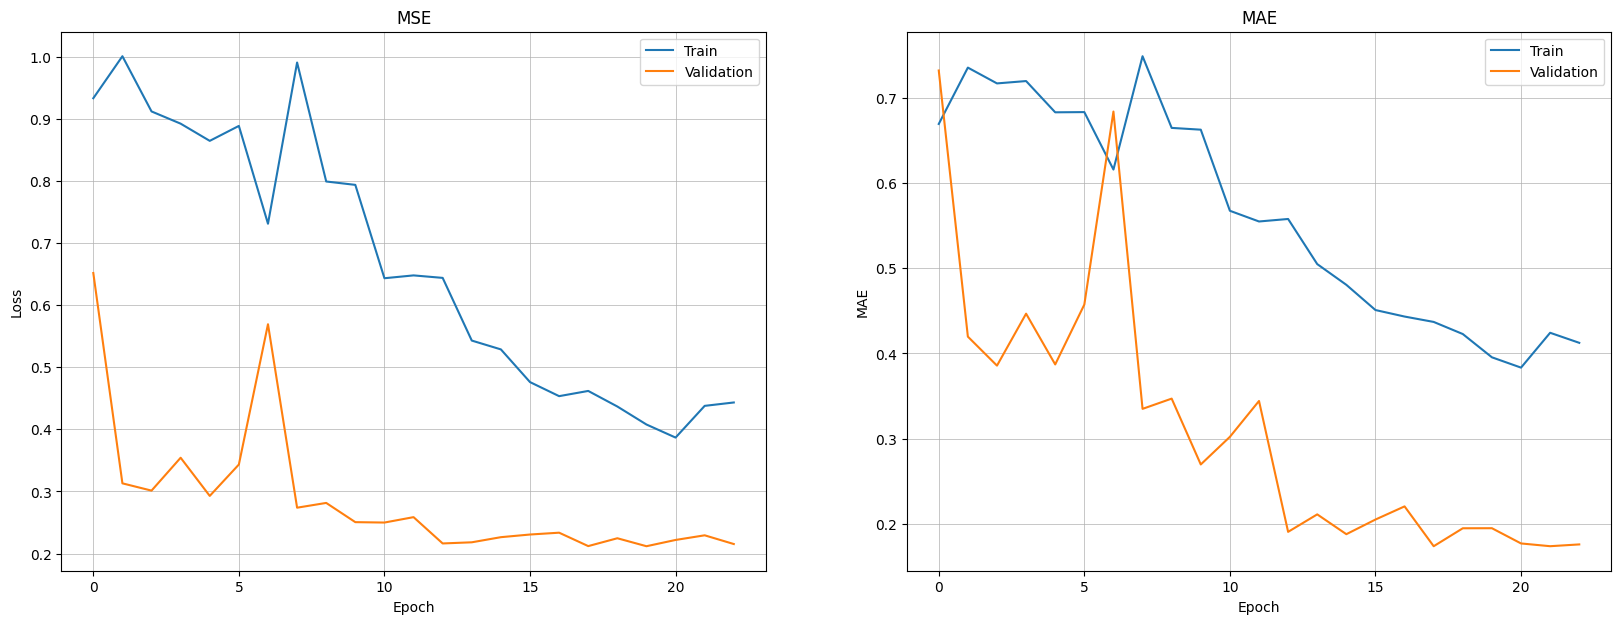

In [563]:
plot_history(history_5)

In [564]:
res5 = model_5.evaluate(X_test_c, y_test_c, verbose=0)
res5

[0.5426031947135925, 0.49569591879844666]

In [550]:
predicted_values = pd.DataFrame(model_5.predict(X_test_c))


12/12 [==============================] - 0s 989us/step


In [552]:
pd.DataFrame(y_test_c)

ValueError: Must pass 2-d input. shape=(371, 1, 1)

### Ben's code

In [262]:
train_start_date = pd.to_datetime('2007-02-01')
train_end_date = pd.to_datetime('2019-12-31')
test_start_date = pd.to_datetime('2020-01-01')
test_end_date = pd.to_datetime('2022-12-31')


df_train = df[(df['Date']>=train_start_date) & (df['Date']<=train_end_date)]
df_test = df[(df['Date']>=test_start_date) & (df['Date']<=test_end_date)]

In [267]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date','Qoil MPFM'])
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df, 3, 1)

(            WHT        WHP  Tubing Gradient  Service Line P     Sand Raw  \
 2643  50.686974  73.639458         0.780439      121.054016  5246.699707   
 2644  50.668972  74.009300         0.773302      118.830940  5240.092773   
 2645  51.247467  78.146263         0.000000      203.512314  5215.871582   
 
        Qgas MPFM   MPFM WCT  MPFM Venturi dP     MPFM T  MPFM CF GOR  \
 2643  496.160766  48.466353      3502.435791  51.472218          1.0   
 2644  503.084203  48.180112      3525.273193  51.456127          1.0   
 2645  127.717811   0.000000      1672.997986  52.371239          1.0   
 
       Manifold T  Manifold P   Jumper T  Choke Opening   Annulus P  
 2643   51.940947   68.852219  51.085567     100.002090  158.418274  
 2644   51.940947   68.676003  51.085567     100.251495  158.299179  
 2645   51.940947   69.249107  51.085567     100.228790  158.155701  ,
 2646    16783.25441
 Name: Qoil MPFM, dtype: float64)

In [268]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [270]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [271]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [281]:
X_test.shape

(1000, 500, 15)

Normalize input and output data

In [64]:
X_train.std(axis=0)

array([[ 8.51934693, 20.16329636,  0.45245535, ...,  8.58585745,
        20.86863086, 26.52418724],
       [ 8.51399973, 20.01679326,  0.45354994, ...,  8.52025743,
        20.96251065, 26.54069083],
       [ 8.91585623, 19.85451554,  0.45901782, ...,  8.73077222,
        21.80722943, 26.7406401 ],
       ...,
       [ 9.21821219, 20.69200768,  0.42586485, ...,  9.0265204 ,
        22.55213307, 26.98504737],
       [ 9.38157444, 20.68156249,  0.42790826, ...,  9.13837639,
        22.94531083, 26.98786544],
       [ 9.44561763, 20.52769943,  0.42790821, ...,  9.38286792,
        22.61358311, 27.04503709]])

In [137]:
X_test.shape

(1000, 500, 15)

#### LSTM with batch normalization

In [273]:
def init_model_6(X_train, y_train):
    
    #normalization
    #normalizer = Normalization(axis=-1)
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(32, activation='tanh'))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [274]:
model_6 = init_model_6(X_train, y_train)
model_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 500, 15)          60        
 hNormalization)                                                 
                                                                 
 lstm_14 (LSTM)              (None, 32)                6144      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,237
Trainable params: 6,207
Non-trainable params: 30
_________________________________________________________________


In [275]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [276]:
model_6, history_6 = fit_model(model_6)

Epoch 1/50
110/110 [==============================] - 9s 73ms/step - loss: 293840384.0000 - mae: 15290.3096 - val_loss: 292420832.0000 - val_mae: 15307.8174
Epoch 2/50
110/110 [==============================] - 8s 70ms/step - loss: 288244960.0000 - mae: 15126.4375 - val_loss: 286907008.0000 - val_mae: 15145.2080
Epoch 3/50
110/110 [==============================] - 8s 70ms/step - loss: 282826048.0000 - mae: 14966.1279 - val_loss: 281524256.0000 - val_mae: 14984.8691
Epoch 4/50
110/110 [==============================] - 8s 70ms/step - loss: 277571840.0000 - mae: 14808.6328 - val_loss: 276256384.0000 - val_mae: 14826.0645
Epoch 5/50
110/110 [==============================] - 8s 71ms/step - loss: 272340960.0000 - mae: 14651.2021 - val_loss: 271077280.0000 - val_mae: 14668.0449
Epoch 6/50
110/110 [==============================] - 8s 71ms/step - loss: 267258000.0000 - mae: 14492.4492 - val_loss: 265999520.0000 - val_mae: 14511.2441
Epoch 7/50
110/110 [==============================] - 8s 7

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

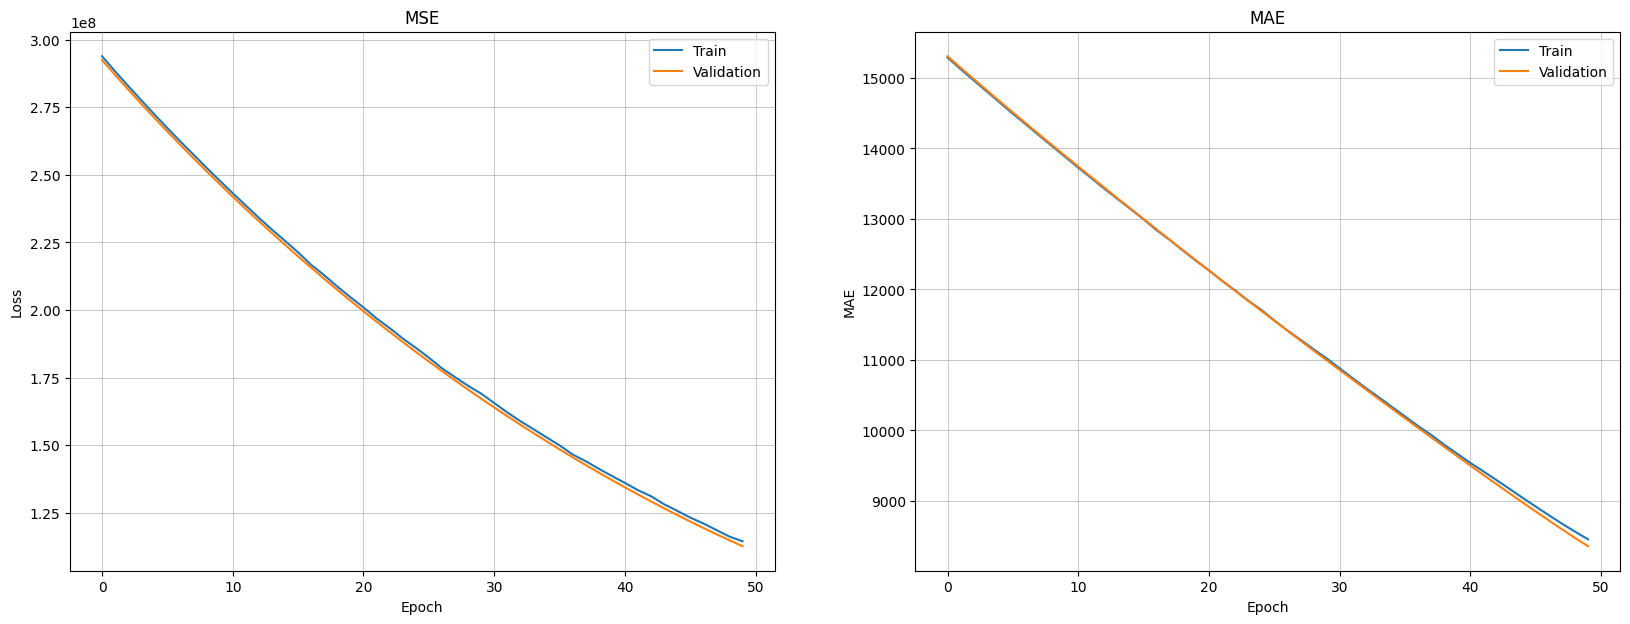

In [277]:
plot_history(history_6)

In [278]:
res6 = model_6.evaluate(X_test, y_test, verbose=0)
res6

[7056731.5, 2440.384033203125]

In [280]:
y_test

array([[10389.04368363],
       [11012.5664764 ],
       [11446.32501791],
       [10896.44069149],
       [ 9929.39610592],
       [10578.55110606],
       [ 9203.35427311],
       [ 9864.26984503],
       [10409.7915366 ],
       [ 9794.58976729],
       [10492.55145704],
       [    0.        ],
       [10477.12905908],
       [10389.04368363],
       [ 9120.1106392 ],
       [10171.86554704],
       [10268.6946194 ],
       [10285.43916752],
       [10653.16851633],
       [11185.20727064],
       [ 9924.05107202],
       [11400.13959466],
       [11204.69977197],
       [10457.96824699],
       [ 1923.87245153],
       [ 9801.12796109],
       [11142.56447274],
       [10730.57073419],
       [10741.84010645],
       [10823.42759757],
       [10217.28048383],
       [ 9430.06847534],
       [ 6427.02377554],
       [    0.        ],
       [10544.19247726],
       [10142.66998374],
       [10621.72483708],
       [10850.52937254],
       [10448.40338887],
       [10325.07257659],


In [282]:
y_pred.shape

(1000, 1)

In [279]:
y_pred = model_6.predict(X_test)
y_pred

32/32 [==============================] - 1s 13ms/step


array([[8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],
       [8130.6714],


In [153]:
def plot_predictions(y_test, y_pred):
    y_test2 = y_test.reshape((y_test.shape[0], y_test.shape[1]))
    plt.plot(y_test2, color='red', label='real')
    plt.plot(y_pred, color='blue', label='predicted')
    plt.legend()
    plt.show()

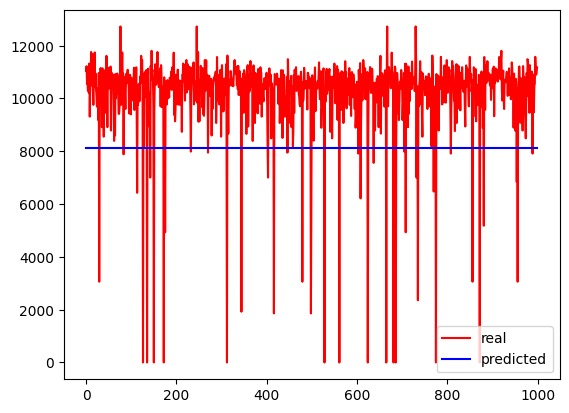

In [154]:
plot_predictions(y_test, y_pred)

#### LSTM with MinMaxScaler:

Scale the data

In [218]:
scaler = MinMaxScaler(feature_range=(0,1))
df_train2 = pd.DataFrame(scaler.fit_transform(df_train.drop(columns='Date')), columns=df_train.drop(columns='Date').columns)
df_test2 = pd.DataFrame(scaler.transform(df_test.drop(columns='Date')), columns=df_test.drop(columns='Date').columns)

In [219]:
df_train2

,WHT,WHP,Tubing Gradient,Service Line P,Sand Raw,Qoil MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold T,Manifold P,Jumper T,Choke Opening,Annulus P
0,0.977248,0.330314,0.339197,0.239343,0.250860,0.285746,0.045807,0.008016,0.245614,0.989176,0.0,0.962612,0.489140,0.981054,0.762066,0.881176
1,0.977248,0.330314,0.339197,0.239343,0.250860,0.285746,0.045807,0.008016,0.245614,0.989176,0.0,0.962612,0.489140,0.981054,0.762066,0.881176
2,0.977248,0.330314,0.339197,0.239343,0.250860,0.285746,0.045807,0.008016,0.245614,0.989176,0.0,0.962612,0.489140,0.981054,0.762066,0.881176
3,0.977248,0.330314,0.339197,0.239343,0.250860,0.285746,0.045807,0.008016,0.245614,0.989176,0.0,0.962612,0.489140,0.981054,0.762066,0.881176
4,0.977248,0.330314,0.339197,0.239343,0.250860,0.285746,0.045807,0.008016,0.245614,0.989176,0.0,0.962612,0.489140,0.981054,0.762066,0.881176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4712,0.990300,0.316789,0.627432,0.238256,0.435005,0.226370,0.017158,0.794650,0.184473,0.999162,0.0,0.997567,0.521823,0.993822,0.820373,0.914887
4713,0.990558,0.328817,0.623870,0.236198,0.355913,0.197358,0.014713,0.822229,0.155089,0.999581,0.0,0.997240,0.541993,0.993715,0.820643,0.915721
4714,0.990199,0.327367,0.624811,0.342559,0.354015,0.199773,0.015229,0.809794,0.153345,0.999283,0.0,0.996656,0.540257,0.993122,0.816775,0.915411
4715,0.989141,0.332846,0.622388,0.327596,0.342476,0.185954,0.019463,0.831456,0.145413,0.999395,0.0,0.996976,0.549536,0.993124,0.814018,0.915570


In [220]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns='Qoil MPFM') 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train2, 3, 1)

(           WHT       WHP  Tubing Gradient  Service Line P  Sand Raw  \
 3412  0.983441  0.267654         0.110731        0.220088  0.229153   
 3413  0.983159  0.265923         0.111983        0.221667  0.230616   
 3414  0.982388  0.265662         0.112172        0.220470  0.229887   
 
       Qgas MPFM  MPFM WCT  MPFM Venturi dP    MPFM T  MPFM CF GOR  Manifold T  \
 3412   0.035675  0.742778         0.217221  0.996757          0.0    0.962445   
 3413   0.032332  0.733257         0.221732  0.996686          0.0    0.962839   
 3414   0.034578  0.721978         0.221644  0.996771          0.0    0.962776   
 
       Manifold P  Jumper T  Choke Opening  Annulus P  
 3412    0.448172  0.982648       0.912164   0.969098  
 3413    0.445015  0.983017       0.905261   0.968800  
 3414    0.444770  0.982936       0.912138   0.968990  ,
 3415    0.254364
 Name: Qoil MPFM, dtype: float64)

In [221]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [222]:
X_train, y_train = get_X_y(sequence=df_train2,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [223]:
X_test, y_test = get_X_y(sequence=df_test2,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [195]:
X_train.shape

(5000, 500, 15)

In [196]:
y_train.shape

(5000, 1)

In [197]:
#scaler = MinMaxScaler(feature_range=(0,1))
#X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1)).reshape(X_train.shape)
#X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1)).reshape(X_test.shape)
#y_train = scaler.fit_transform(y_train.reshape(y_train.shape[0],-1)).reshape(y_train.shape)
#y_test = scaler.transform(y_test.reshape(y_test.shape[0],-1)).reshape(y_test.shape)

In [200]:
def init_model_7(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [201]:
model_7 = init_model_7(X_train, y_train)
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                2048      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,065
Trainable params: 2,065
Non-trainable params: 0
_________________________________________________________________


In [202]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [203]:
model_7, history_7 = fit_model(model_7)

Epoch 1/50
110/110 [==============================] - 7s 49ms/step - loss: 0.0642 - mae: 0.1637 - val_loss: 0.0192 - val_mae: 0.0997
Epoch 2/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0161 - mae: 0.0891 - val_loss: 0.0128 - val_mae: 0.0826
Epoch 3/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0123 - mae: 0.0763 - val_loss: 0.0097 - val_mae: 0.0714
Epoch 4/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0106 - mae: 0.0694 - val_loss: 0.0086 - val_mae: 0.0621
Epoch 5/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0096 - mae: 0.0642 - val_loss: 0.0084 - val_mae: 0.0598
Epoch 6/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0081 - mae: 0.0595 - val_loss: 0.0054 - val_mae: 0.0404
Epoch 7/50
110/110 [==============================] - 5s 47ms/step - loss: 0.0072 - mae: 0.0536 - val_loss: 0.0053 - val_mae: 0.0428
Epoch 8/50
110/110 [==============================] - 5s 47ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

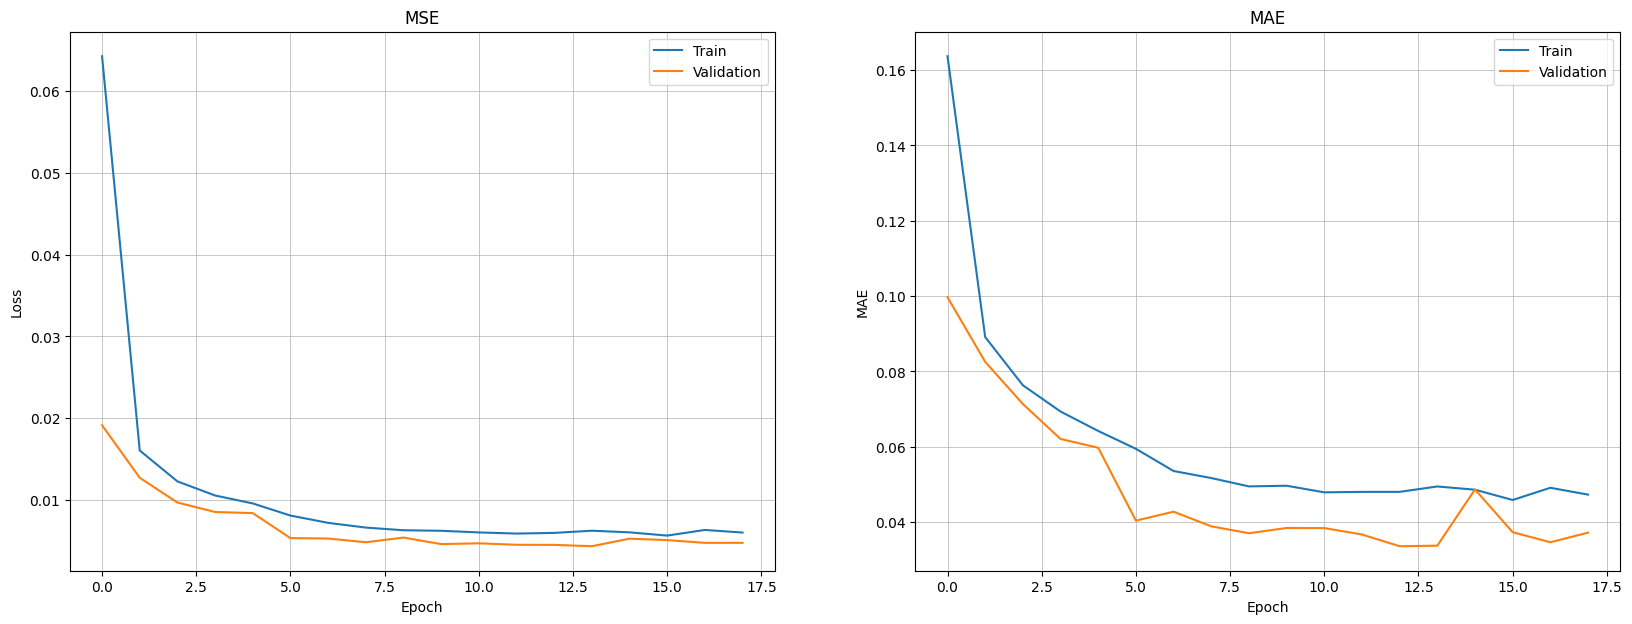

In [204]:
plot_history(history_7)

In [205]:
res7 = model_7.evaluate(X_test, y_test, verbose=0)
res7

[0.0013461884809657931, 0.028451140969991684]

In [206]:
y_pred = model_7.predict(X_test)
y_pred

32/32 [==============================] - 0s 9ms/step


array([[0.19159931],
       [0.18515775],
       [0.19538987],
       [0.17254472],
       [0.19585282],
       [0.1908901 ],
       [0.19647245],
       [0.18214184],
       [0.18977988],
       [0.1908867 ],
       [0.19448748],
       [0.1823127 ],
       [0.18694597],
       [0.1797876 ],
       [0.183487  ],
       [0.1969257 ],
       [0.20342425],
       [0.18214184],
       [0.19092363],
       [0.06361543],
       [0.19765145],
       [0.13111866],
       [0.18888147],
       [0.1880404 ],
       [0.18411401],
       [0.19202559],
       [0.19149277],
       [0.18569824],
       [0.20602992],
       [0.18931161],
       [0.18585561],
       [0.19068089],
       [0.1908901 ],
       [0.1920447 ],
       [0.19098681],
       [0.19021572],
       [0.18101195],
       [0.18931161],
       [0.1824227 ],
       [0.18648088],
       [0.17992182],
       [0.17952672],
       [0.18942128],
       [0.19338287],
       [0.19078273],
       [0.18418574],
       [0.18208723],
       [0.184

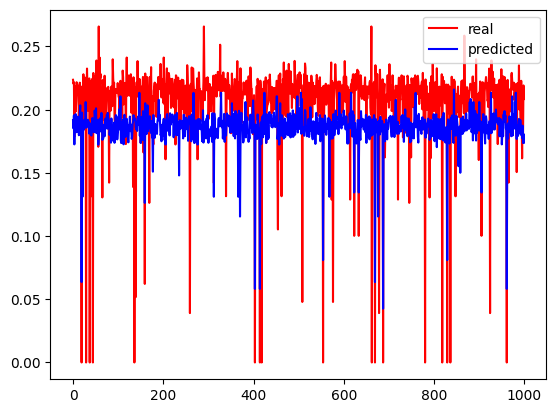

In [207]:
plot_predictions(y_test, y_pred)

#### Second LSTM with MinMaxScaler

In [243]:
def init_model_8(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    #model.add(layers.LSTM(8, activation='tanh'))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [244]:
model_8 = init_model_8(X_train, y_train)
model_8.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 16)                2048      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,065
Trainable params: 2,065
Non-trainable params: 0
_________________________________________________________________


In [245]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [246]:
model_8, history_8 = fit_model(model_8)

Epoch 1/50
125/125 [==============================] - 5s 32ms/step - loss: 0.0520 - mae: 0.1532 - val_loss: 0.0213 - val_mae: 0.1059
Epoch 2/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0165 - mae: 0.0929 - val_loss: 0.0117 - val_mae: 0.0841
Epoch 3/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0110 - mae: 0.0724 - val_loss: 0.0095 - val_mae: 0.0694
Epoch 4/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0091 - mae: 0.0633 - val_loss: 0.0061 - val_mae: 0.0493
Epoch 5/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0085 - mae: 0.0596 - val_loss: 0.0054 - val_mae: 0.0433
Epoch 6/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0085 - mae: 0.0598 - val_loss: 0.0052 - val_mae: 0.0409
Epoch 7/50
125/125 [==============================] - 4s 31ms/step - loss: 0.0077 - mae: 0.0585 - val_loss: 0.0053 - val_mae: 0.0406
Epoch 8/50
125/125 [==============================] - 4s 31ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

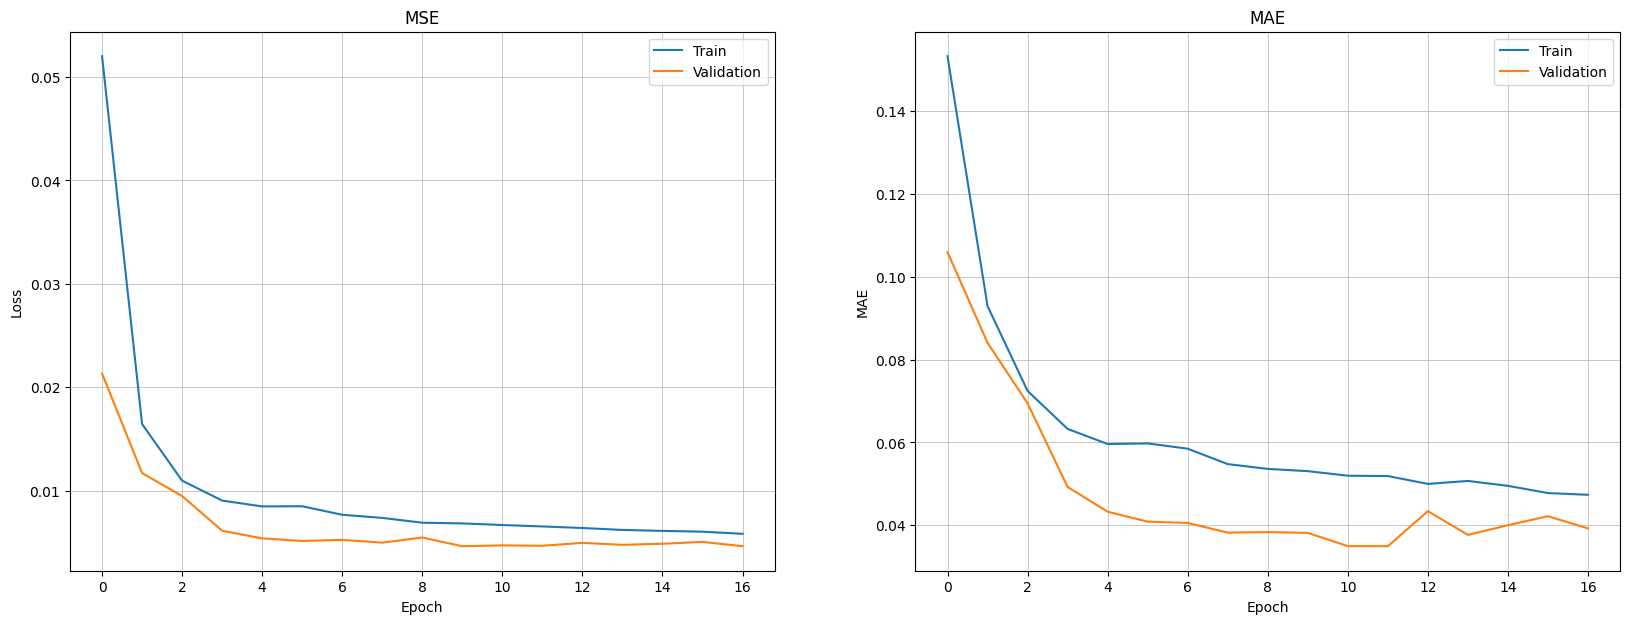

In [247]:
plot_history(history_8)

In [248]:
res8 = model_8.evaluate(X_test, y_test, verbose=0)
res8

[0.0006698156939819455, 0.012588420882821083]

In [249]:
y_pred = model_8.predict(X_test)
y_pred

32/32 [==============================] - 0s 9ms/step


array([[0.21198599],
       [0.21178481],
       [0.20237699],
       [0.22097339],
       [0.22130977],
       [0.21804014],
       [0.2066209 ],
       [0.22089109],
       [0.2029572 ],
       [0.21063888],
       [0.21661852],
       [0.20907599],
       [0.22194779],
       [0.22667828],
       [0.19520742],
       [0.21928316],
       [0.20477727],
       [0.21220586],
       [0.21201691],
       [0.21030101],
       [0.20553371],
       [0.23262545],
       [0.02026621],
       [0.21211058],
       [0.21446484],
       [0.19899622],
       [0.20023145],
       [0.22671464],
       [0.21417086],
       [0.2062135 ],
       [0.22215909],
       [0.22905056],
       [0.22130977],
       [0.21544412],
       [0.22615486],
       [0.22158289],
       [0.22356085],
       [0.22319534],
       [0.19918182],
       [0.21953103],
       [0.21767132],
       [0.19913211],
       [0.19898331],
       [0.19913211],
       [0.21385103],
       [0.23039547],
       [0.2299263 ],
       [0.221

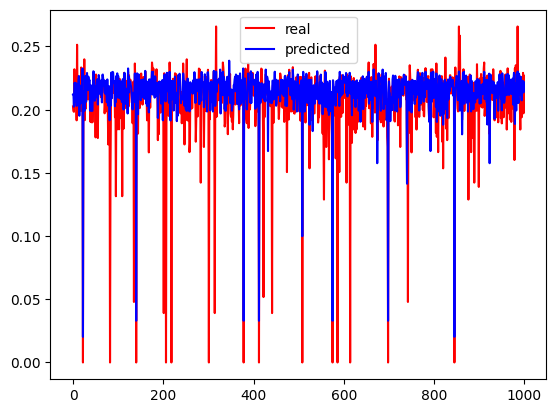

In [250]:
plot_predictions(y_test, y_pred)

In [259]:
y_pred_1d = y_pred.reshape(-1)
y_pred_1d

array([0.21198599, 0.21178481, 0.20237699, 0.22097339, 0.22130977,
       0.21804014, 0.2066209 , 0.22089109, 0.2029572 , 0.21063888,
       0.21661852, 0.20907599, 0.22194779, 0.22667828, 0.19520742,
       0.21928316, 0.20477727, 0.21220586, 0.21201691, 0.21030101,
       0.20553371, 0.23262545, 0.02026621, 0.21211058, 0.21446484,
       0.19899622, 0.20023145, 0.22671464, 0.21417086, 0.2062135 ,
       0.22215909, 0.22905056, 0.22130977, 0.21544412, 0.22615486,
       0.22158289, 0.22356085, 0.22319534, 0.19918182, 0.21953103,
       0.21767132, 0.19913211, 0.19898331, 0.19913211, 0.21385103,
       0.23039547, 0.2299263 , 0.22160317, 0.20704916, 0.21856803,
       0.20928854, 0.21790217, 0.21614103, 0.22315235, 0.22391115,
       0.20404546, 0.21838202, 0.22741657, 0.22430404, 0.21669851,
       0.22288698, 0.21202978, 0.22165638, 0.22318694, 0.2057488 ,
       0.22741657, 0.2278263 , 0.22348294, 0.21929124, 0.22318694,
       0.21361609, 0.21277113, 0.22278601, 0.21231262, 0.21410

In [260]:
y_test_1d = y_test.reshape(-1)
y_test_1d

array([0.20256679, 0.19903778, 0.19829901, 0.23197655, 0.20826092,
       0.21279311, 0.21147971, 0.21612084, 0.19157357, 0.25138264,
       0.21168762, 0.22442573, 0.21268233, 0.21659213, 0.21121139,
       0.21578376, 0.20756876, 0.1989816 , 0.23339207, 0.21386139,
       0.20865631, 0.23000512, 0.        , 0.20161167, 0.20000902,
       0.23985594, 0.19169657, 0.21836696, 0.20070823, 0.2118904 ,
       0.20922952, 0.22631668, 0.20826092, 0.20808455, 0.21501621,
       0.21546253, 0.21898305, 0.21595364, 0.19058741, 0.21480514,
       0.21257676, 0.19002635, 0.20528305, 0.19002635, 0.20103385,
       0.22951981, 0.22230753, 0.22106923, 0.20664613, 0.21469672,
       0.17808151, 0.22781965, 0.20750645, 0.21678706, 0.22259312,
       0.17756721, 0.21766852, 0.22359216, 0.22142461, 0.2137653 ,
       0.21562243, 0.2183288 , 0.20985011, 0.21841672, 0.21038677,
       0.22359216, 0.21820163, 0.22282611, 0.21717194, 0.21841672,
       0.19712203, 0.20295158, 0.21479709, 0.19859711, 0.20209

In [284]:
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

ValueError: non-broadcastable output operand with shape (1000,1) doesn't match the broadcast shape (1000,16)